# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
from PIL import Image


from scipy.ndimage import gaussian_filter


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers



# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Preparing the Data 

Fixing Target Column 

In [3]:
# Convert the string representation of lists in 'target' column to actual lists
df_data['target'] = df_data['target'].apply(ast.literal_eval)

# Verify the conversion by displaying the first few rows of the 'target' column
df_data['target'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 0, 0, 0, 0]
2    [0, 1, 0, 0, 0, 0, 0, 0]
3    [0, 1, 0, 0, 0, 0, 0, 0]
4    [0, 1, 0, 0, 0, 0, 0, 0]
Name: target, dtype: object

Splitting Dataset into Training and Testing Sets

In [4]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

# Check the size of the training and test sets
train_size = df_train.shape[0]
test_size = df_test.shape[0]

(train_size, test_size)

(5113, 1279)

Splitting Training Data into Training and Validation Sets 

In [5]:
# Further split the df_train into training and validation sets
df_train_final, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)

# Check the size of the new training and validation sets
train_final_size = df_train_final.shape[0]
validation_size = df_validation.shape[0]

(train_final_size, validation_size)

(4090, 1023)

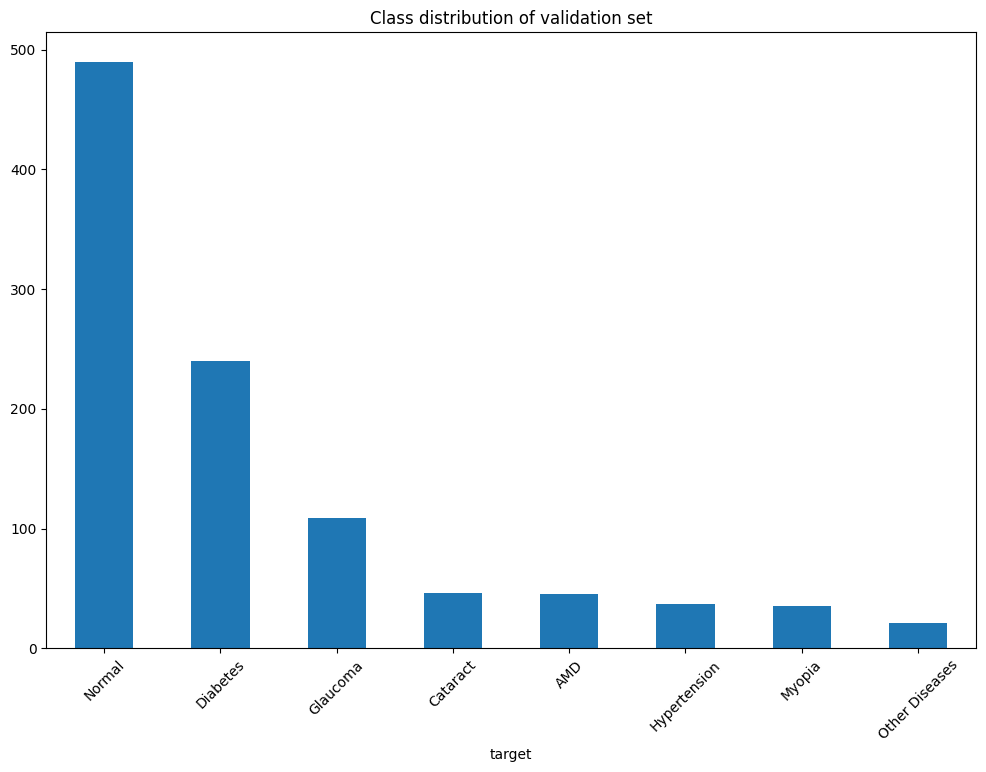

In [6]:
# class distribution of validation set
df_validation['target'].value_counts()

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# plot distribution of classes
plt.figure(figsize=(12, 8))
df_validation['target'].value_counts().plot(kind='bar')
plt.title('Class distribution of validation set')
plt.xticks(ticks=np.arange(8), labels=class_labels, rotation=45)
plt.show()




# Class Distribution
- Below is shown the distribution of images available for each different ocular condition. This distribution shows a significant imbalance, with "Normal" and "Diabetes" conditions being the most represented, while conditions like "Hypertension" and "Glaucoma" have far fewer images.

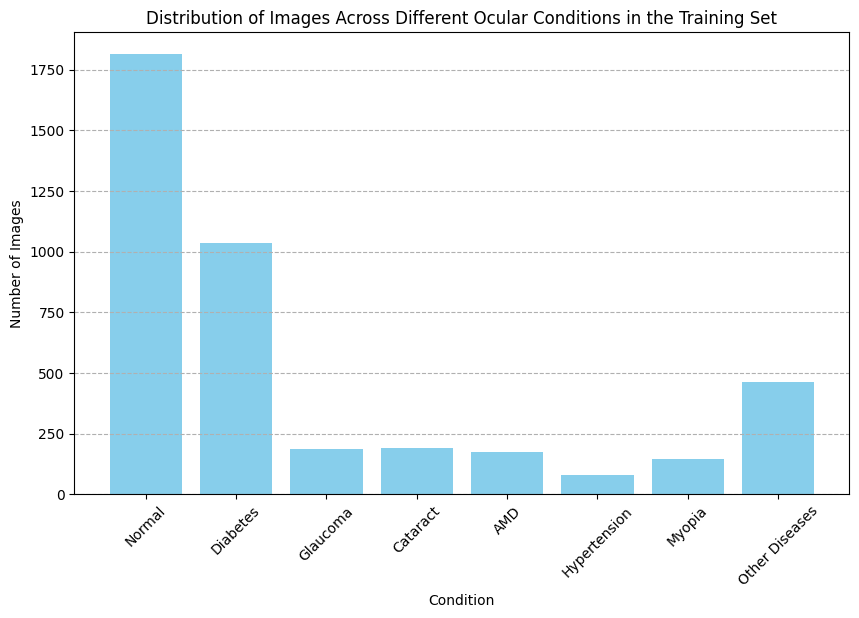

{'Normal': 1814,
 'Diabetes': 1035,
 'Glaucoma': 188,
 'Cataract': 190,
 'AMD': 174,
 'Hypertension': 79,
 'Myopia': 147,
 'Other Diseases': 463}

In [7]:
# Sum up all the target lists to get the class distribution
class_distribution = np.sum(df_train_final['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order as per your earlier description
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values(), color='skyblue')
plt.title('Distribution of Images Across Different Ocular Conditions in the Training Set')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

# Also, return the class distribution for detailed examination
class_distribution_dict

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [25]:
# Initialize the ImageDataGenerator for the validation set
validation_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the validation generator
validation_generator = validation_augmentation.flow_from_dataframe(
    dataframe=df_validation,
    directory='dataset/preprocessed_images',
    x_col='filename',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1023 validated image filenames belonging to 8 classes.


In [24]:
df_train_final.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
5535,3231,58,Female,3231_left.jpg,3231_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3231_left.jpg
5760,3960,55,Male,3960_left.jpg,3960_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",3960_left.jpg
1273,1657,50,Female,1657_left.jpg,1657_right.jpg,lens dust，pathological myopia,mild nonproliferative retinopathy,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",1657_right.jpg
3432,277,75,Male,277_left.jpg,277_right.jpg,normal fundus,drusen,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",277_left.jpg
3510,364,45,Male,364_left.jpg,364_right.jpg,myelinated nerve fibers,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",364_left.jpg


In [26]:
# Create the training generator
train_augmentation = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_augmentation.flow_from_dataframe(
    dataframe=df_train_final,
    directory='dataset/preprocessed_images',
    x_col='filename',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4090 validated image filenames belonging to 8 classes.


In [27]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split

# Create the test generator
test_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_augmentation.flow_from_dataframe(
    dataframe=df_test,
    directory='dataset/preprocessed_images',
    x_col='filename',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1279 validated image filenames belonging to 8 classes.


In [130]:
x,y = test_generator.next()
x.shape

(32, 224, 224, 3)

# Loading and Visualising the Training Data 

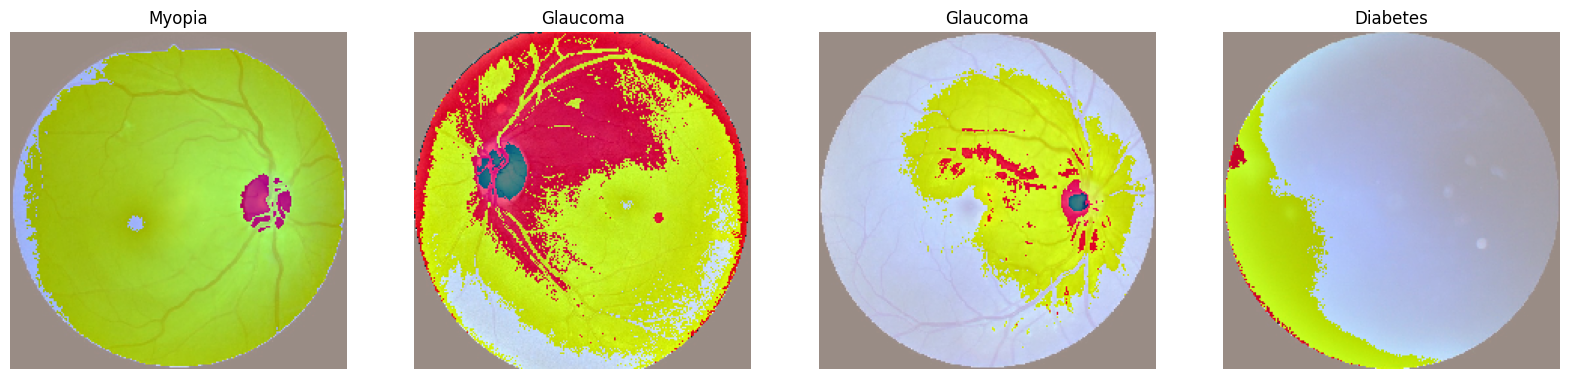

In [28]:
# Get the next batch of images from the training generator
images, labels = next(train_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

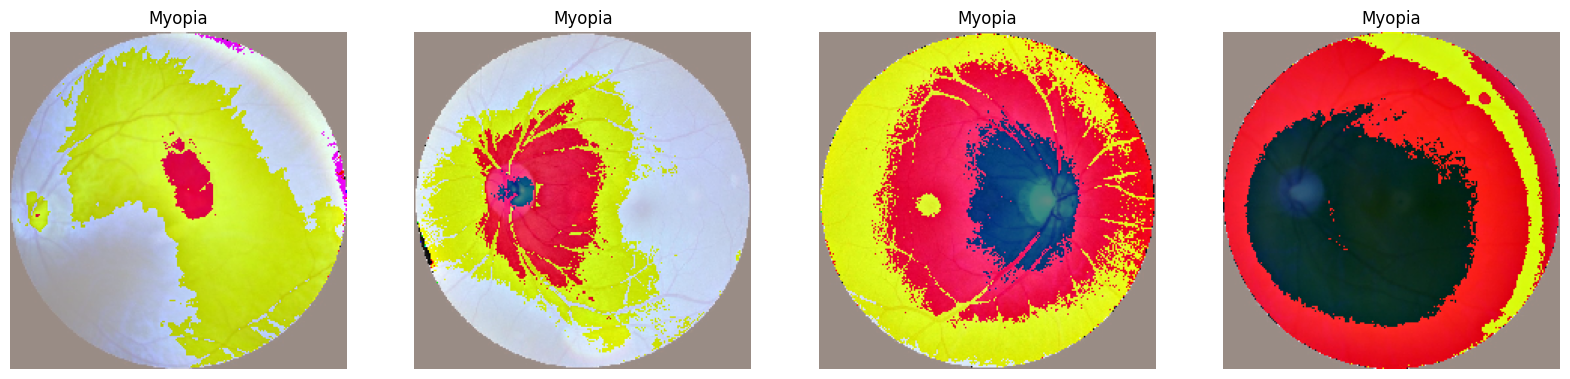

In [29]:
images, labels = next(validation_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [30]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [early_stopping, checkpoint, reduce_lr]


In [31]:
# Recreate the model
resnet_50_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224,224, 3),
    pooling='avg',
    classes=8,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(256, activation='relu'))
resnet_50_model.add(Dropout(0.5))
resnet_50_model.add(BatchNormalization())
resnet_50_model.add(Dense(8, activation='softmax'))

# Compile the model
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
resnet_50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                      

In [33]:
steps_per_epoch=train_generator.samples // 32
print(steps_per_epoch)

validation_steps=validation_generator.samples // 32

127


In [23]:
# Fit the model with callbacks
history = resnet_50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Number of unique classes: 2


# Evaluating Model 

Model Accuracy Graph Analysis

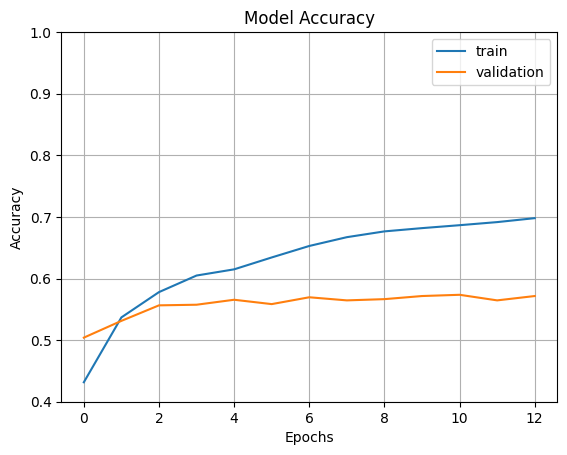

In [119]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

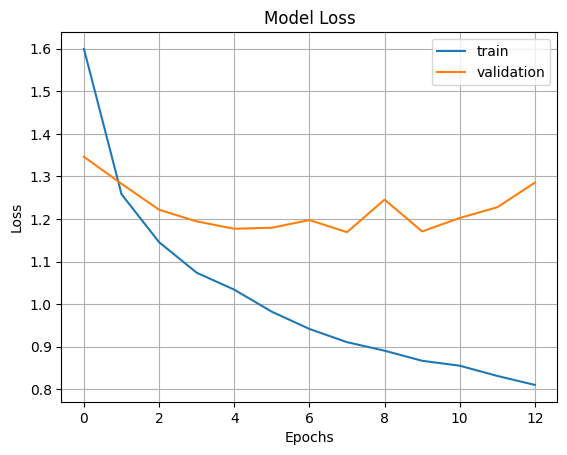

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [121]:
model_best = keras.models.load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_acc = model_best.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

# Get the predictions for the test set

predictions = model_best.predict(test_generator, verbose=1)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

40/40 [==============================] - 6s 129ms/step - loss: 1.2240 - accuracy: 0.5528
Test accuracy: 0.5528
40/40 [==============================] - 5s 114ms/step


In [81]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_generator, steps=steps)

# Re-generate predictions with the corrected steps
predictions = resnet_50_model.predict(test_generator, steps=steps)

# Get the predicted classes again
predicted_classes = np.argmax(predictions, axis=1)


80/80 [==============================] - 6s 65ms/step


# Predictions Result Evaluation

In [98]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [122]:

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Get the true classes from the DataFrame
true_classes = test_generator.classes

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.40      0.17      0.24        46
      Diabetes       0.73      0.71      0.72        58
      Glaucoma       0.55      0.25      0.34       333
      Cataract       0.46      0.21      0.29        61
           AMD       0.21      0.11      0.14        28
  Hypertension       0.86      0.88      0.87        48
        Myopia       0.54      0.90      0.67       569
Other diseases       0.54      0.05      0.09       136

      accuracy                           0.55      1279
     macro avg       0.54      0.41      0.42      1279
  weighted avg       0.55      0.55      0.49      1279



Balanced Accuracy Score 

In [123]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4091


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [124]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8016


Confusion Matrix 

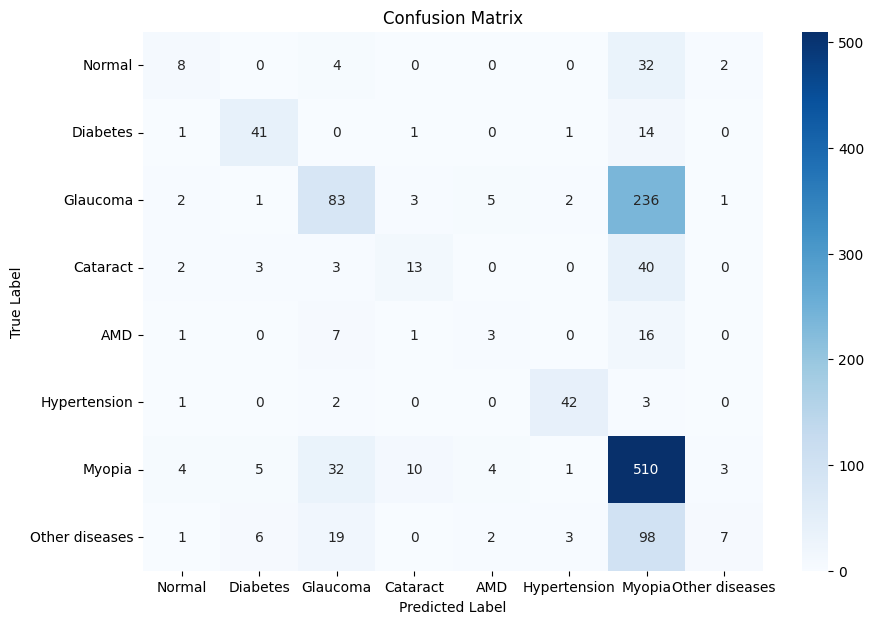

In [125]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

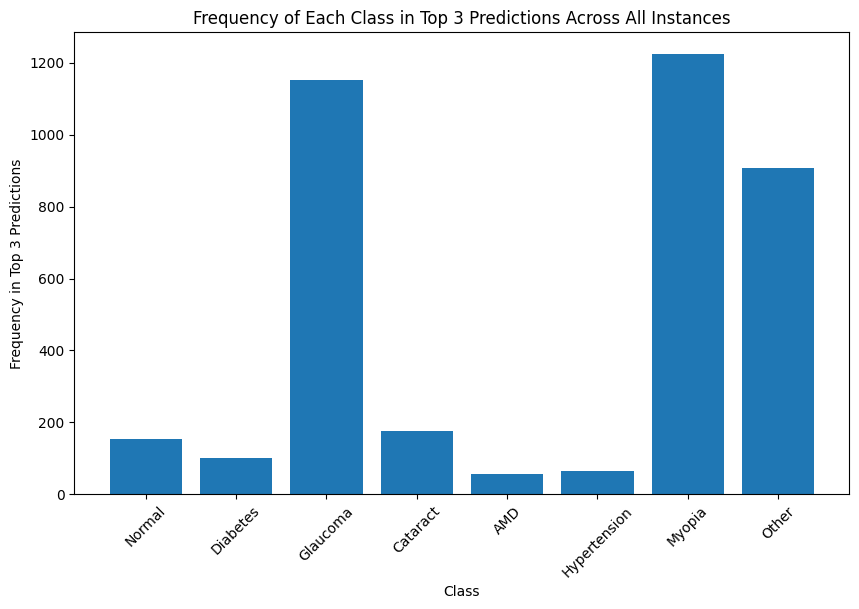

In [58]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')